<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/dbda/ch09-heirarchical-models/heirarchical_on_mint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from runpy import run_path

az.style.use('arviz-darkgrid')
%matplotlib inline

In [66]:
!rm -rf data-science-hw
!git clone https://github.com/ctarrington/data-science-hw.git

base_path = './data-science-hw/dbda/ch08-basic-models/'
Coin = run_path(base_path+'/mint.py').get('Coin')
Mint = run_path(base_path+'/mint.py').get('Mint')

Cloning into 'data-science-hw'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 140 (delta 67), reused 16 (delta 3), pack-reused 0
Receiving objects: 100% (140/140), 739.47 KiB | 6.54 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [67]:
coins_per_mint = 3
mint = Mint(0.3, 0.025)
coins = mint.make_coins(coins_per_mint)

mint = Mint(0.7, 0.025)
mint.make_coins(coins_per_mint, coins)

In [68]:
flips = []
for ctr in range(20):
  for coin in coins:
    coin.flip(flips)

In [69]:
df = pd.DataFrame(flips, columns=['mint_id', 'coin_id', 'flip'])
df.head()

,mint_id,coin_id,flip
0,0,0,0
1,0,1,1
2,0,2,0
3,1,3,1
4,1,4,0


In [70]:
coin_id = df['coin_id']
mint_id = df['mint_id']

num_coins = len(np.unique(coin_id))
num_mints = len(np.unique(mint_id))

print('num_coins', num_coins)
print('num_mints', num_mints)

num_coins 6
num_mints 2


## No Heirarchy

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:02<00:00, 967.13it/s] 
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


       mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
θ[0]  0.229  0.086   0.083    0.395  ...  4944.0    5399.0    2958.0    1.0
θ[1]  0.180  0.078   0.050    0.328  ...  4615.0    4887.0    3003.0    1.0
θ[2]  0.274  0.092   0.105    0.442  ...  4636.0    4934.0    3138.0    1.0
θ[3]  0.771  0.089   0.601    0.930  ...  5566.0    5373.0    2994.0    1.0
θ[4]  0.591  0.101   0.397    0.773  ...  4392.0    4429.0    3279.0    1.0
θ[5]  0.726  0.095   0.553    0.895  ...  5434.0    5398.0    3245.0    1.0

[6 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarnin

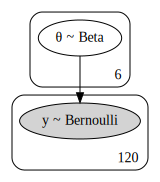

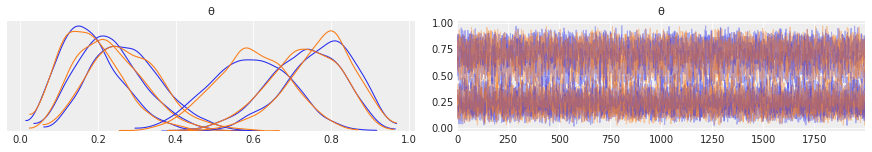

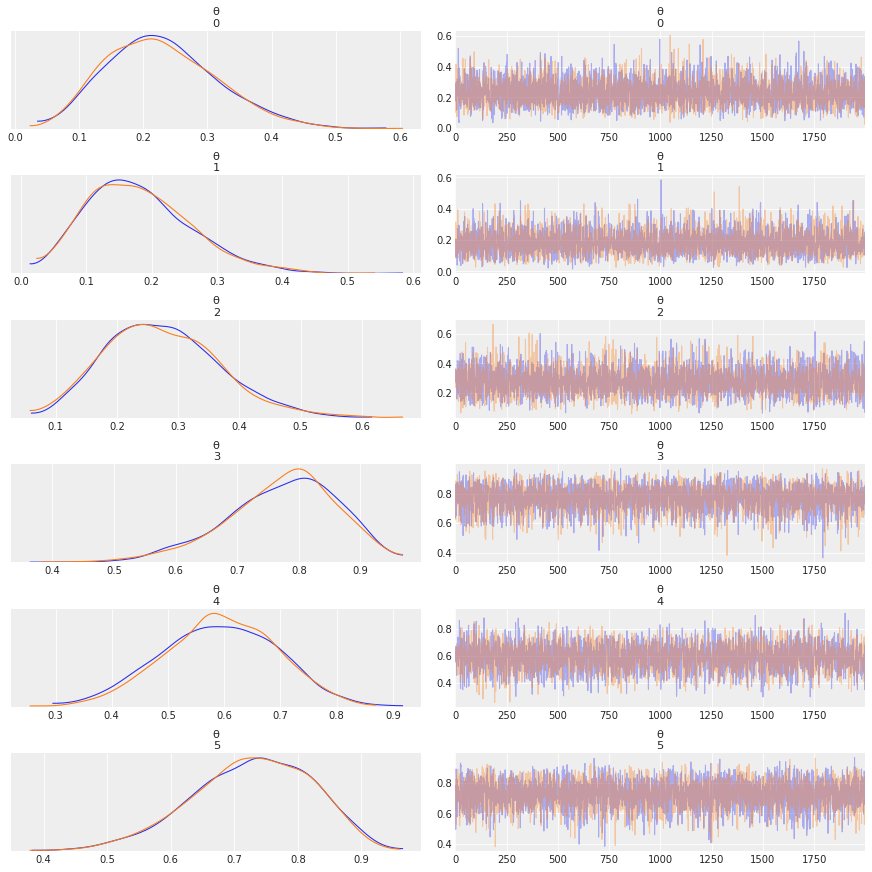

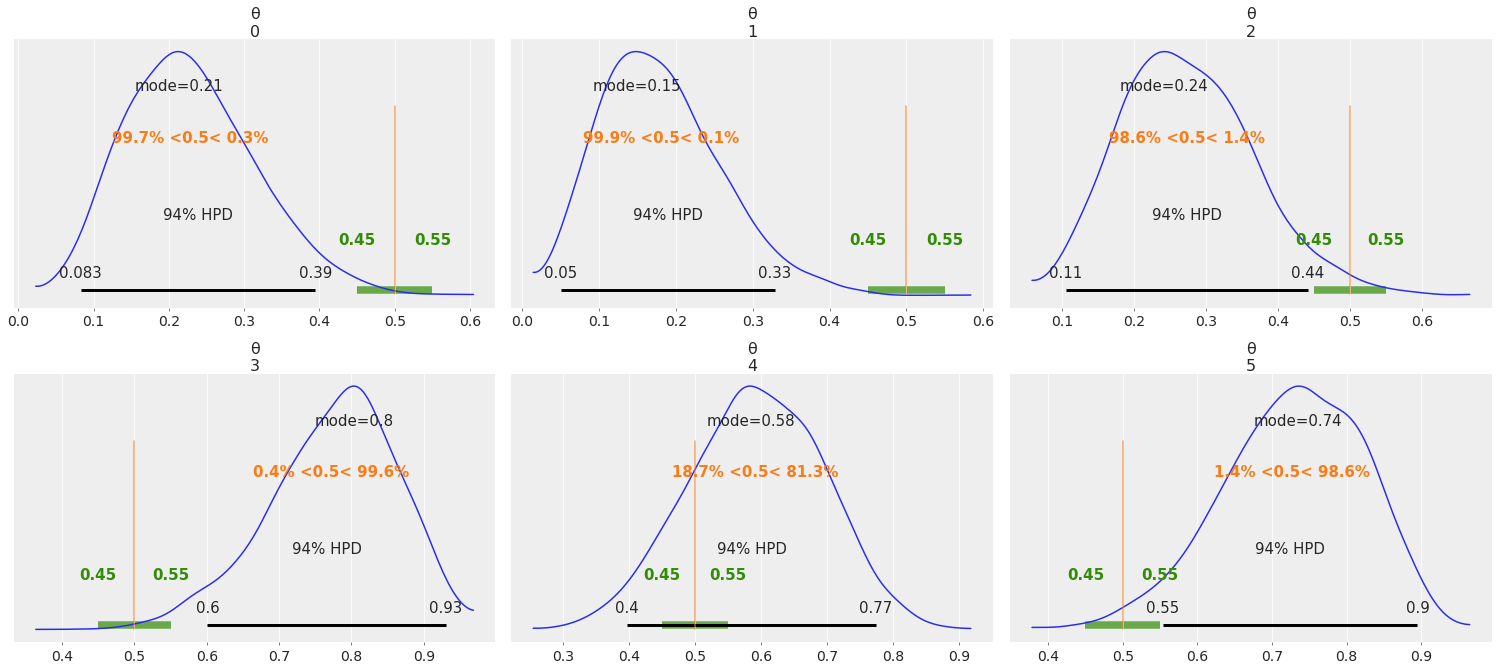

In [71]:
with pm.Model() as model:
  θ = pm.Beta('θ', alpha=1., beta=1., shape=num_coins)   # uniform prior
  
  y = pm.Bernoulli('y', p=θ[coin_id], observed=df['flip']) # likelihood p(y|θ)

  trace = pm.sample(2000, random_seed=123)
  print(az.summary(trace))
  pm.traceplot(trace)
  az.plot_trace(trace)
  az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model)

## Heirarchy under Mint

In [72]:
grouped = df.groupby(['mint_id', 'coin_id']).agg({'flip': [np.sum, np.size]}).reset_index()
grouped.columns = ['mint_id', 'coin_id', 'heads', 'total']

# mint id series needs to be the length of the mints
mint_id = grouped['mint_id']

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ_coin, κ_mint, μ_mint]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:06<00:00, 390.01it/s]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(input

             mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
μ_mint[0]   0.252  0.091   0.099    0.426  ...  3073.0    3512.0    2823.0    1.0
μ_mint[1]   0.682  0.099   0.495    0.855  ...  3356.0    3298.0    2909.0    1.0
κ_mint[0]  11.430  5.980   1.772   22.367  ...  3729.0    3222.0    1976.0    1.0
κ_mint[1]  11.073  5.931   1.500   21.966  ...  3603.0    3112.0    2381.0    1.0
θ_coin[0]   0.216  0.079   0.080    0.364  ...  5001.0    5168.0    2772.0    1.0
θ_coin[1]   0.183  0.076   0.046    0.321  ...  4497.0    4415.0    2535.0    1.0
θ_coin[2]   0.250  0.083   0.108    0.412  ...  4570.0    4993.0    2903.0    1.0
θ_coin[3]   0.763  0.082   0.616    0.913  ...  4476.0    4388.0    2926.0    1.0
θ_coin[4]   0.631  0.093   0.444    0.788  ...  4789.0    4833.0    2953.0    1.0
θ_coin[5]   0.730  0.084   0.572    0.883  ...  5492.0    5493.0    2751.0    1.0

[10 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarnin

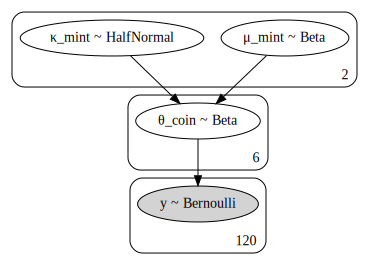

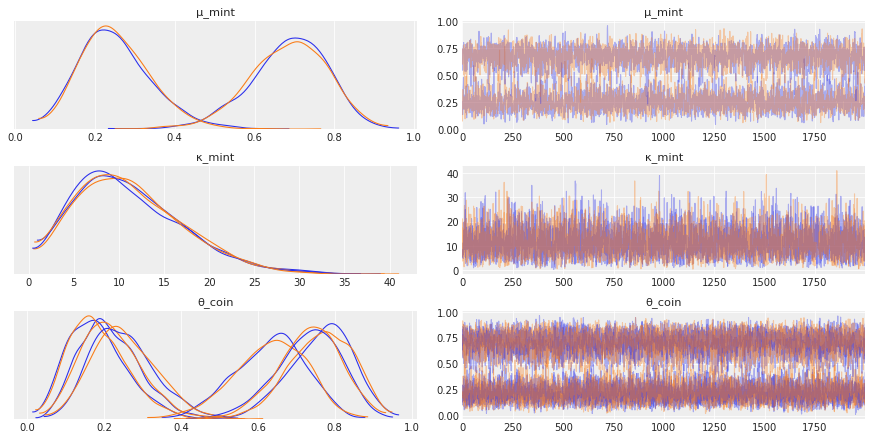

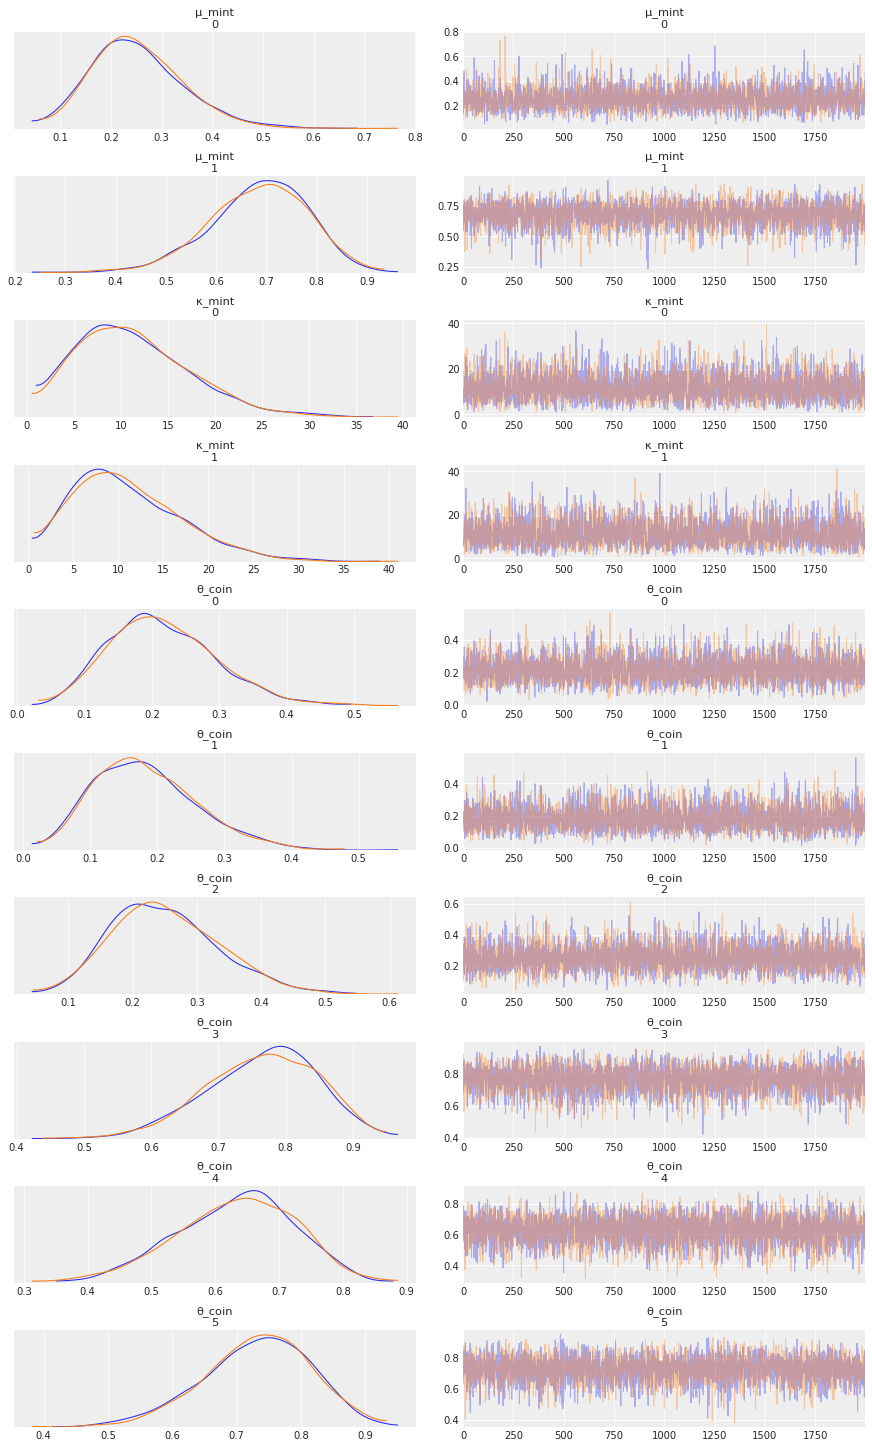

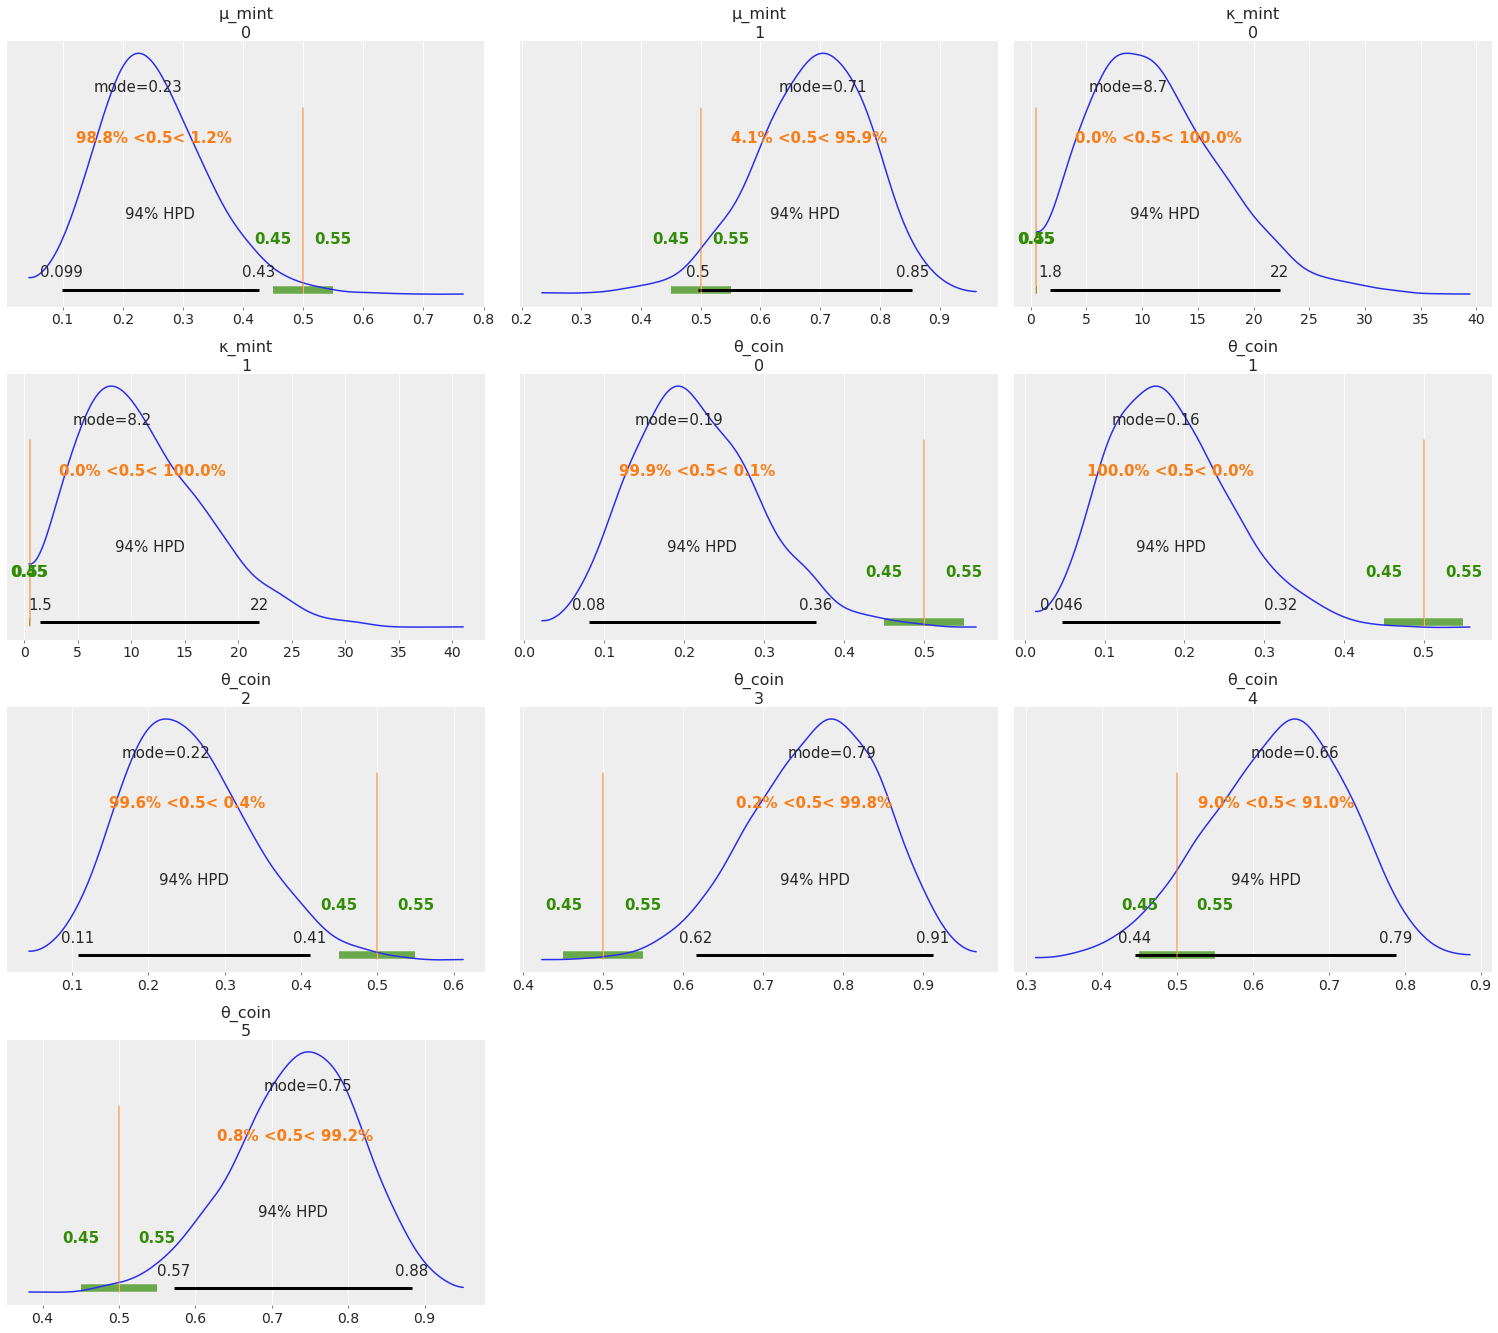

In [73]:
with pm.Model() as model_h_mint:
    μ_mint = pm.Beta('μ_mint', 1., 1., shape=num_mints)
    κ_mint = pm.HalfNormal('κ_mint', 10, shape=num_mints)    

    θ_coin = pm.Beta('θ_coin', alpha=μ_mint[mint_id]*κ_mint[mint_id], beta=(1.0-μ_mint[mint_id])*κ_mint[mint_id], shape=num_coins)
    y_p = θ_coin[coin_id]
    y = pm.Bernoulli('y', p=y_p, observed=df['flip']) # likelihood p(y|θ)
  
    trace = pm.sample(2000, random_seed=123)
    print(az.summary(trace))
    pm.traceplot(trace)
    az.plot_trace(trace)
    az.plot_posterior(trace, rope=[0.45, 0.55], ref_val=0.5, point_estimate='mode')

pm.model_to_graphviz(model_h_mint)